# Import Necessary Library functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
from tensorflow.keras.models import load_model 
import json
from tensorflow.keras.utils import to_categorical
from pathlib import Path

In [2]:
# Helper function to load and preprocess images
def load_and_preprocess_image(base_dir, path, target_size):
    """
    Loads an image from the given path, preprocesses it, and returns the preprocessed image array.

    Parameters:
    - base_dir: The base directory where images are located.
    - path: The relative path to the image file.
    - target_size: A tuple specifying the target size for resizing the image (width, height).
    
    Returns:
    - preprocessed_img: The preprocessed image array, ready for model input.
    """
    img_path = os.path.join(base_dir, path.replace('\\', '/'))
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    preprocessed_img = preprocess_input(img_array) # Apply predefined preprocessing
    return preprocessed_img

# Function to load training data from an Excel file
def get_data_for_training(excel_path, base_dir, image_size=(32, 32)):
    """
    Loads image data and labels for training from an Excel file and preprocesses the images.

    Parameters:
    - excel_path: The file path to the Excel file containing image paths and labels.
    - base_dir: The base directory where images are located.
    - image_size: A tuple specifying the target size for resizing the images (default: (32, 32)).
    
    Returns:
    - X: An array of preprocessed images.
    - y: The corresponding label array for the images.
    - df['image_path'].values: A list of the image paths.
    """
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path']) # Removes rows where image path is missing
    class_names = df.columns[2:] # Columns representing class labels start from the third column
    X = np.array([load_and_preprocess_image(base_dir, path, image_size) for path in tqdm(df['image_path'].values)])
    y = df[class_names].values
    return X, y, df['image_path'].values

In [3]:
# Focal Loss function definition
def focal_loss(gamma=2.0, alpha=0.25):
     # Focal Loss function to address class imbalance by focusing on hard-to-classify examples.
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon()) # Clip predictions to avoid log(0) errors
        cross_entropy_loss = -y_true * tf.math.log(y_pred)
        modulating_factor = tf.pow(1.0 - y_pred, gamma)  # Apply modulating factor to down-weight easy examples.
        focal_loss = alpha * modulating_factor * cross_entropy_loss # Calculate final focal loss.
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))
    return focal_loss_fixed

In [4]:
# Functions for evaluation (from organizers)
def save_predictions_to_excel(image_paths, y_pred, output_path):
    """
    Saves predictions along with their probabilities and image paths to an Excel file.

    Parameters:
    - image_paths: List of image file paths.
    - y_pred: Array of predicted class probabilities (shape: [n_samples, n_classes]).
    - output_path: File path for saving the Excel file.
    """
    
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    y_pred_classes = np.argmax(y_pred, axis=1)
    predicted_class_names = [class_columns[i] for i in y_pred_classes]
    
    df_prob = pd.DataFrame(y_pred, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)
    df_class = pd.DataFrame({'image_path': image_paths, 'predicted_class': predicted_class_names})
    
    df_merged = pd.merge(df_prob, df_class, on='image_path')
    df_merged.to_excel(output_path, index=False)

def calculate_specificity(y_true, y_pred):
     """
    Calculates specificity: TN / (TN + FP).
    
    Parameters:
    - y_true: Ground truth binary labels (0 or 1).
    - y_pred: Predicted binary labels (0 or 1).
    
    Returns:
    - specificity: Specificity score, or 0 if denominator is zero.
    """
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return specificity

In [5]:
# Functions to save metrics (from organizers)
def generate_metrics_report(y_true, y_pred):
    """
    Generates a comprehensive metrics report for a multi-class classification problem.
    
    Parameters:
    - y_true: Ground truth labels, one-hot encoded (numpy array of shape (n_samples, n_classes)).
    - y_pred: Predicted probabilities for each class (numpy array of shape (n_samples, n_classes)).
    
    Returns:
    - metrics_report: A JSON string containing various performance metrics including AUC-ROC, 
                      specificity, average precision, sensitivity, F1-score, and balanced accuracy.
    """
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    metrics_report = {}

    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_columns, output_dict=True, zero_division=0)

    auc_roc_scores = {class_name: roc_auc_score(y_true[:, i], y_pred[:, i]) for i, class_name in enumerate(class_columns)}
    mean_auc_roc = np.mean(list(auc_roc_scores.values()))
    auc_roc_scores['mean_auc'] = mean_auc_roc

    specificity_scores = {class_name: calculate_specificity(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int)) for i, class_name in enumerate(class_columns)}
    mean_specificity = np.mean(list(specificity_scores.values()))
    specificity_scores['mean_specificity'] = mean_specificity

    average_precision_scores = {}
    for i, class_name in enumerate(class_columns):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision_scores[class_name] = auc(recall, precision) if len(precision) > 0 else 0.0
    mean_average_precision = np.mean(list(average_precision_scores.values()))
    average_precision_scores['mean_average_precision'] = mean_average_precision

    sensitivity_scores = {class_name: recall_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0) for i, class_name in enumerate(class_columns)}
    mean_sensitivity = np.mean(list(sensitivity_scores.values()))
    sensitivity_scores['mean_sensitivity'] = mean_sensitivity

    f1_scores = {class_name: f1_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0) for i, class_name in enumerate(class_columns)}
    mean_f1_score = np.mean(list(f1_scores.values()))
    f1_scores['mean_f1_score'] = mean_f1_score

    balanced_accuracy = balanced_accuracy_score(y_true_classes, y_pred_classes)

    metrics_report.update(class_report)
    metrics_report['auc_roc_scores'] = auc_roc_scores
    metrics_report['specificity_scores'] = specificity_scores
    metrics_report['average_precision_scores'] = average_precision_scores
    metrics_report['sensitivity_scores'] = sensitivity_scores
    metrics_report['f1_scores'] = f1_scores
    metrics_report['mean_auc'] = mean_auc_roc
    metrics_report['mean_specificity'] = mean_specificity
    metrics_report['mean_average_precision'] = mean_average_precision
    metrics_report['mean_sensitivity'] = mean_sensitivity
    metrics_report['mean_f1_score'] = mean_f1_score
    metrics_report['balanced_accuracy'] = balanced_accuracy

    return json.dumps(metrics_report, indent=4)

# Data Loading and Preprocessing

In [6]:
# Load data for training and validation
train_excel_path = "/kaggle/input/capsule-vision/Dataset/training/training_data.xlsx"
val_excel_path = "/kaggle/input/capsule-vision/Dataset/validation/validation_data.xlsx"
base_dir = "/kaggle/input/capsule-vision/Dataset"
image_size = (75, 75)

X_train, y_train, _ = get_data_for_training(train_excel_path, base_dir, image_size=image_size)
X_val, y_val, image_paths = get_data_for_training(val_excel_path, base_dir, image_size=image_size)

100%|██████████| 16132/16132 [00:56<00:00, 285.00it/s]


# Defining and Training Model

In [7]:
# Load pre-trained ResNet50 without the top layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model.trainable = True

# Build the model on top of ResNet50
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')  # 10 classes for output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
# Define a ReduceLROnPlateau callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

# Define an EarlyStopping callback to stop training early when validation accuracy stops improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=1,
                                              mode = 'max', restore_best_weights = True)

# Train the model and include the checkpoint callback
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=256, callbacks=[reduce_lr,early_stop])

Epoch 1/30


I0000 00:00:1728668318.997310     128 service.cc:145] XLA service 0x7e28c4001960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728668318.997362     128 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728668348.745426     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 126s 444ms/step - accuracy: 0.7242 - loss: 0.1659 - val_accuracy: 0.8311 - val_loss: 0.0868 - learning_rate: 1.0000e-04
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.9063 - loss: 0.0383 - val_accuracy: 0.8899 - val_loss: 0.0491 - learning_rate: 1.0000e-04
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.9454 - loss: 0.0211 - val_accuracy: 0.8910 - val_loss: 0.0486 - learning_rate: 1.0000e-04
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.9641 - loss: 0.0116 - val_accuracy: 0.8954 - val_loss: 0.0532 - learning_rate: 1.0000e-04
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 205ms/step - accuracy: 0.9723 - loss: 0.0083 - val_accuracy: 0.8933 - val_loss: 0.0567 - learning_rate: 1.0000e-04
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.9796 - loss: 0.0065 - val_accuracy: 0.8983 - val_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 205ms/step -

In [9]:
np.save('/kaggle/working/resnet_history.npy',history.history) # Save the training history of the model to a .npy file for later analysis
model.save('ResNet50_cv.h5')

# Model Evaluation

505/505 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step
Validation results with probabilities saved to /kaggle/working/validation_results.xlsx
Confusion Matrix:
[[6.96177062e-01 4.02414487e-03 1.67002012e-01 8.04828974e-03
  4.02414487e-03 0.00000000e+00 1.00603622e-01 2.01207243e-02
  0.00000000e+00 0.00000000e+00]
 [1.67130919e-02 7.93871866e-01 1.11420613e-01 1.67130919e-02
  0.00000000e+00 2.78551532e-03 3.34261838e-02 2.50696379e-02
  0.00000000e+00 0.00000000e+00]
 [2.85714286e-02 2.94372294e-02 6.90909091e-01 3.37662338e-02
  1.29870130e-02 5.19480519e-03 1.54978355e-01 4.24242424e-02
  1.73160173e-03 0.00000000e+00]
 [2.02020202e-02 2.02020202e-02 3.36700337e-01 3.97306397e-01
  1.01010101e-02 3.36700337e-03 1.04377104e-01 1.04377104e-01
  3.36700337e-03 0.00000000e+00]
 [5.88235294e-03 2.94117647e-03 8.23529412e-02 5.88235294e-03
  7.61764706e-01 5.88235294e-03 9.11764706e-02 4.41176471e-02
  0.00000000e+00 0.00000000e+00]
 [8.74635569e-03 2.91545190e-03 6.99708455e-02 2.91545190e-03
  2.9

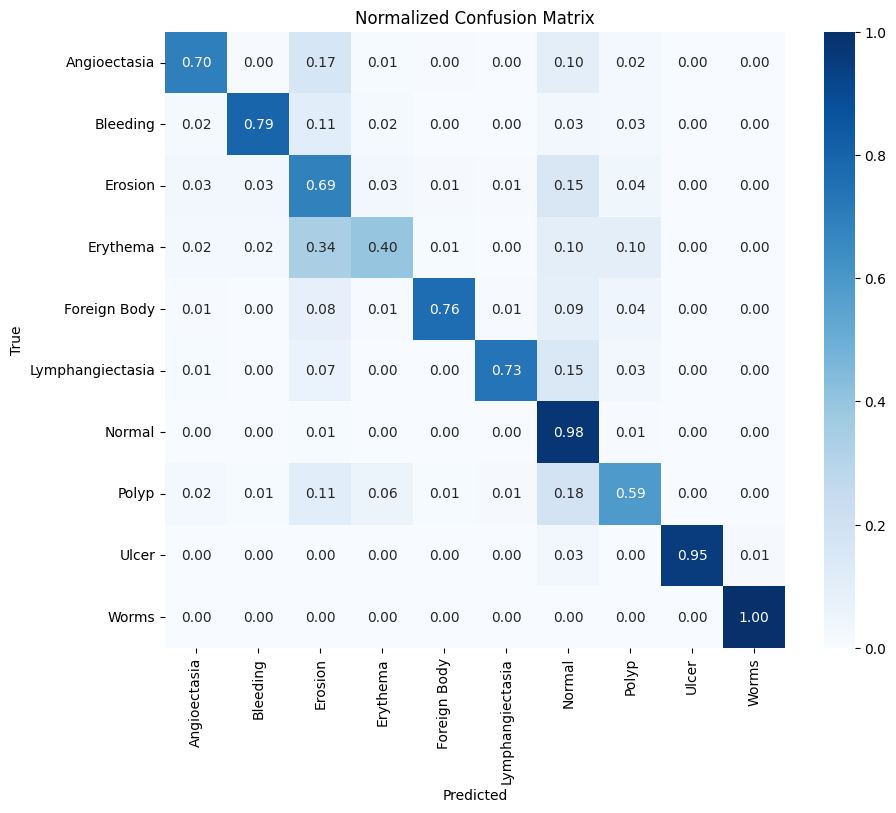

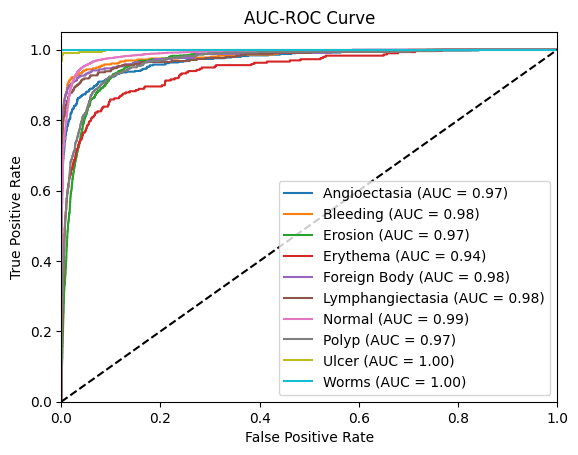

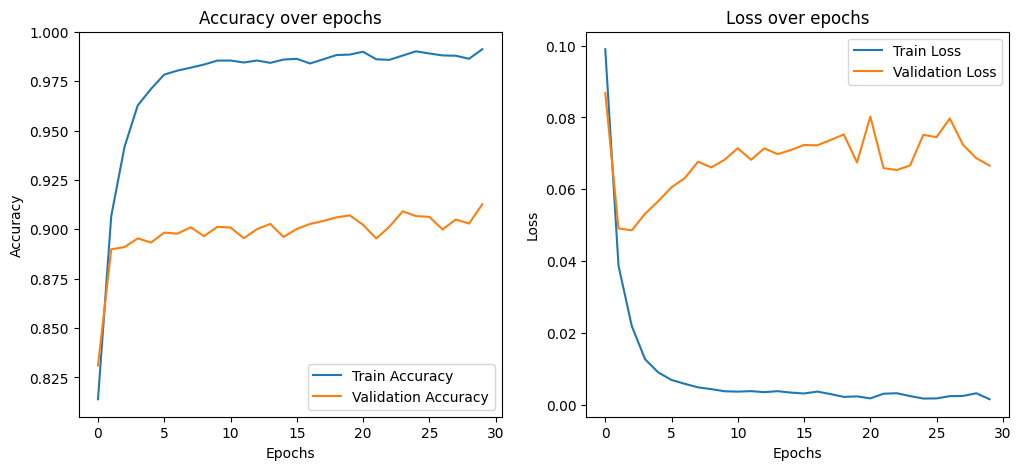

Confusion matrix saved to /kaggle/working/confusion_matrix.png
AUC-ROC curve saved to /kaggle/working/roc_curve.png
Training/validation accuracy and loss plots saved to /kaggle/working/train_val_plots.png
Evaluation metrics report saved to /kaggle/working/metrics_report.json


In [10]:
# Predict on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class indices
y_val_classes = np.argmax(y_val, axis=1)  # Get actual class indices

# List of class names (if they are not already in the same order as the one-hot encoded 'y_val')
class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

# Convert the class indices back to class names for both actual and predicted values
actual_class_names = [class_columns[i] for i in y_val_classes]
predicted_class_names = [class_columns[i] for i in y_pred_classes]

# Create a DataFrame with the predicted probabilities for each class (y_pred)
df_predictions = pd.DataFrame(y_pred, columns=class_columns)

# Add the image paths, actual class, and predicted class to the DataFrame
df_predictions.insert(0, 'image_path', image_paths)  # Insert image names as the first column
df_predictions['predicted_class'] = predicted_class_names  # Add predicted class as a column
df_predictions['actual_class'] = actual_class_names  # Add actual class as a column

# Save to Excel
output_path = '/kaggle/working/validation_results.xlsx'
df_predictions.to_excel(output_path, index=False)

print(f"Validation results with probabilities saved to {output_path}")

# Print Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')
print(cm)

# Print Classification Report
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes, target_names=class_names))

# Plot normalized Confusion Matrix and save it as PNG
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
conf_matrix_path = '/kaggle/working/confusion_matrix.png'
plt.savefig(conf_matrix_path, format='png')  # Save the confusion matrix plot as PNG
plt.show()

# Plot AUC-ROC curve for each class and save it as PNG
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val_classes)
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
roc_curve_path = '/kaggle/working/roc_curve.png'
plt.savefig(roc_curve_path, format='png')  # Save the AUC-ROC curve plot as PNG
plt.show()

# Plot training & validation accuracy and loss over epochs and save them as PNG
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

train_val_plot_path = '/kaggle/working/train_val_plots.png'
plt.savefig(train_val_plot_path, format='png')  # Save the accuracy and loss plot as PNG
plt.show()

# Generate and save evaluation metrics as JSON
metrics_report = generate_metrics_report(y_val, y_pred)
metrics_report_path = '/kaggle/working/metrics_report.json'
with open(metrics_report_path, 'w') as f:
    f.write(metrics_report)

# Output file paths
print(f"Confusion matrix saved to {conf_matrix_path}")
print(f"AUC-ROC curve saved to {roc_curve_path}")
print(f"Training/validation accuracy and loss plots saved to {train_val_plot_path}")
print(f"Evaluation metrics report saved to {metrics_report_path}")

# Testing

In [11]:
# Function to load and preprocess a single image
def load_and_preprocess_image_test(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match the model input
    preprocessed_img = preprocess_input(img_array)
    return preprocessed_img

# Path to the test images
test_image_dir = '/kaggle/input/capsule-vision-test/Testing set/Images'

# Get all image file names in the test directory
test_image_paths = [os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith('.jpg')]

# List of class names (as per your dataset)
class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

# Empty lists to store results
image_names = []
predictions = []

# Suppress TensorFlow logs and verbose output
tf.get_logger().setLevel('ERROR')

# Iterate over all test images and make predictions
for image_path in tqdm(test_image_paths, desc="Processing images", unit="image"):
    # Preprocess the image
    img = load_and_preprocess_image_test(image_path, target_size=(75, 75))  # Adjust the target size if needed

    # Predict using the model
    pred = model.predict(img, verbose=0)  # Suppressing verbose output

    # Store the image name and prediction
    image_names.append(os.path.basename(image_path))  # Just the image file name
    predictions.append(pred[0])  # Append the predicted probabilities

# Save the DataFrame to Excel
output_path = '/kaggle/working/test_predictions.xlsx'
save_predictions_to_excel(image_names, predictions, output_path)
print(f"Predictions saved to {output_path}")

Processing images: 100%|██████████| 4385/4385 [04:40<00:00, 15.64image/s]


Predictions saved to /kaggle/working/test_predictions.xlsx


In [ ]:
# Modify the pathname to match the requirement of submission
# Read the Excel file into a DataFrame
df = pd.read_excel('/kaggle/working/test_predictions.xlsx')

# Apply the Path().name method to extract just the image name and its extension
df['image_path'] = df['image_path'].apply(lambda x: Path(x).name)

# Save the modified DataFrame back to an Excel file
df.to_excel('/kaggle/working/updated_test_predictions.xlsx', index=False)

print("File saved successfully with image names and extensions.")